<a href="https://colab.research.google.com/github/tonykipkemboi/odsc-workshop-flow/blob/main/ODSC_East_2025_Getting_Started_With_AI_Agents.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Building Code Documentation Agents with CrewAI + Gemini Flash 2.5**

## *ODSC East 2025 - [Tony Kipkemboi](https://www.linkedin.com/in/tonykipkemboi)*

---

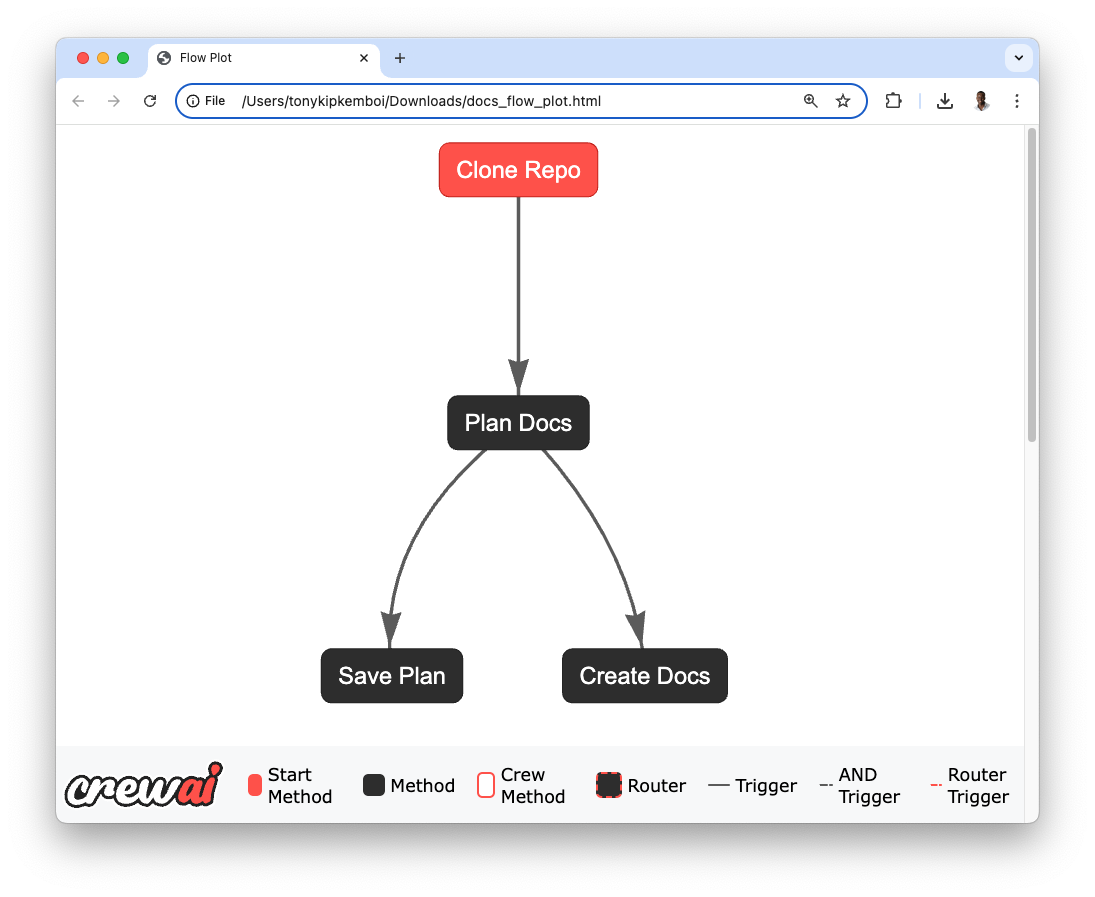

## Imports & Setup

---
- Install the required dependencies


In [ ]:
%pip install -qq crewai crewai-tools pydantic nest_asyncio pyyaml weave

- Apply a patch to allow nested asyncio loops in Jupyter

In [5]:
import nest_asyncio
nest_asyncio.apply()

- Initialize Google API access

In [6]:
from google.colab import userdata
import google.generativeai as genai

GEMINI_API_KEY = userdata.get('GEMINI_API_KEY')
os.environ["GEMINI_API_KEY"] = GEMINI_API_KEY
os.environ["GOOGLE_API_KEY"] = GEMINI_API_KEY

genai.configure(api_key=GEMINI_API_KEY)

- Import CrewAI classes and initialize LLM class with Gemini

In [ ]:
from crewai import Agent, Task, Crew, LLM
from crewai.flow.flow import Flow, listen, start
from crewai_tools import DirectoryReadTool, FileReadTool, WebsiteSearchTool
from crewai.tasks import TaskOutput
import os

llm = LLM(model="gemini/gemini-2.5-pro-preview-05-06")

## Define the Repo & Data Models

---
- Any repo you want to generate documentation for. I'll use one of my old demo repo but feel free to choose one you like.
- Define data structures to capture documentation planning output


In [8]:
import sys
import time
import threading
import os
import yaml
import subprocess
from pathlib import Path
from pydantic import BaseModel
from typing import List
import re

In [9]:
repo_url = "https://github.com/tonykipkemboi/codellama-70b-streamlit-demos"


class DocItem(BaseModel):
    """Represents a documentation item"""
    title: str = ""
    description: str = ""
    prerequisites: str = ""
    examples: list[str] = []
    goal: str = ""

class DocPlan(BaseModel):
    """Documentation plan"""
    overview: str = ""
    docs: list[DocItem] = []

## Crew 1: Planning Crew


---
- This crew specializes in planning the documentation writing and has the following agents and their respective tasks as part of the crew:
  *   **code_explorer**: creates a structural map of the repo
  *   **documentation_planner**: comes up with the documentation plan
- At the end of the cell, we bring all the agents together in a **Crew** class to form the crew




### Code Explorer Agent + Task

In [10]:
code_explorer = Agent(
    role="Repository Architecture Specialist",
    goal="""Create a comprehensive structural map of the repository that identifies all key components,
    their relationships, dependencies, and architectural patterns while highlighting the most critical elements for documentation""",
    backstory="""You are a renowned software architect who has analyzed over 500 open-source repositories throughout your 18-year career.
    You've developed a proprietary methodology for quickly understanding complex codebases that has been adopted by several Fortune 500 companies.
    Your specialty is reverse-engineering architectural patterns from code, and you've published papers on detecting design patterns in codebases.
    You have a particular talent for distinguishing between core business logic and supporting infrastructure,
    allowing you to prioritize what truly matters in a codebase. You believe that understanding code structure
    is foundational to creating effective documentation.""",
    verbose=True,
    llm=llm,
    tools=[
        DirectoryReadTool(),
        FileReadTool()
    ]
)

code_explorer_task = Task(
    description=f"""
    Analyze the codebase at {{repo_path}} to understand its structure and architecture.

    First, explore the overall repository organization:
    1. Identify main directories and their purposes
    2. Locate configuration files and understand their significance
    3. Find entry points (main executables, key functions)
    4. Map dependencies between components

    Then analyze in detail:
    1. Core components and their responsibilities
    2. Key classes/functions and their relationships
    3. Design patterns and architectural approaches used
    4. Data flow through the system
    5. API boundaries and interfaces

    Finally, evaluate:
    1. Which components are most critical to understand
    2. How the code is organized (monolithic, microservices, etc.)
    3. What documentation would be most valuable for different user types

    Take a systematic approach, working from high-level structure to specific implementation details.
    Provide a comprehensive analysis that will enable the documentation team to create effective documentation.
    """,
    expected_output="A detailed analysis of the codebase structure and architecture with clear hierarchy of components and their relationships",
    agent=code_explorer
)

### Documentation Planner Agent + Task

In [11]:
documentation_planner = Agent(
    role="Technical Documentation Architect specializing in developer-centric content strategy",
    goal="""Design a documentation plan that comprehensively covers all essential components with
    optimal organization, ensuring each element has clear purpose, proper sequencing, and
    addresses the needs of multiple developer personas""",
    backstory="""You've spent 12 years creating documentation strategies for developer tools and
    open-source projects that are consistently praised for their clarity and completeness.
    You previously led documentation teams at three major technology companies where you established documentation standards now used industry-wide.
    You have a background in both software development and technical writing, giving you unique insight into what developers actually need from documentation.
    You've developed a framework for documentation planning that ensures no critical information is overlooked while maintaining a logical
    learning progression for readers. You firmly believe that proper planning is what separates excellent documentation from merely adequate documentation.""",
    verbose=True,
    llm=llm,
    tools=[
        DirectoryReadTool(),
        FileReadTool()
    ]
)


documentation_planner_task = Task(
    description="""
    Based on the codebase analysis, create a comprehensive documentation plan.

    The plan should include:
    1. An overview of the project
    2. A list of documentation components to create
    3. For each component:
       - Title
       - Description of what should be covered
       - Prerequisites users should know
       - Examples that should be included
       - Overall goal of the documentation component

    Structure your response as a valid JSON object that follows the DocPlan schema.
    """,
    expected_output="A structured documentation plan in JSON format following the DocPlan schema",
    agent=documentation_planner,
    context=[code_explorer_task],
    output_pydantic=DocPlan
)

### Create the Planning Crew

In [12]:
planning_crew = Crew(
    agents=[code_explorer, documentation_planner],
    tasks=[code_explorer_task, documentation_planner_task],
    verbose=True
)

## Crew 2: Documentation Crew


---
- Crew 2 has the following agents:
  - **overview_writer**: writes docs according to the plan
  - **documentation_reviewer**: docs qa agent


### Documentation Writer Agent + Task

In [13]:
documentation_writer = Agent(
    role="Technical Documentation Writer specializing in developer documentation with visualization expertise",
    goal="""Craft clear, comprehensive documentation with precisely chosen examples, intuitive explanations of
    complex concepts, and effective visualizations that accelerate developer understanding and implementation""",
    backstory="""You have documented over 50 open-source projects throughout your career, earning recognition for
    your ability to make complex systems accessible. You have a rare combination of technical depth and communication
    clarity that allows you to translate difficult concepts into approachable documentation. You've mastered the art of
    choosing the perfect examples that illuminate concepts without overwhelming readers. You're known for your skill with
    technical diagrams and have given workshops on using Mermaid for code visualization. You've developed a documentation
    style that balances completeness with readability, ensuring developers can both understand concepts and quickly find
    specific information. You believe that great documentation should make developers feel empowered rather than confused.""",
    verbose=True,
    llm=llm,
    tools=[
        DirectoryReadTool(),
        FileReadTool(),
        WebsiteSearchTool(
            website="https://mermaid.js.org/intro/",
            config=dict(
                embedder=dict(
                    provider="google",
                    config=dict(
                        model="gemini-embedding-exp-03-07"
                    ),
                )
            )
        )
    ]
)

documentation_writer_task = Task(
    description="""
    Create comprehensive documentation for the component described below:

    Title: {title}
    Project Overview: {overview}
    Component Description: {description}
    Prerequisites: {prerequisites}
    Required Examples: {examples}
    Documentation Goal: {goal}

    Your documentation should:
    1. Be clear, concise, and easy to follow
    2. Include code examples where appropriate
    3. Use markdown formatting with proper headings
    4. Include diagrams using Mermaid syntax when helpful
    5. Follow technical documentation best practices

    Use the WebsiteSearchTool to find correct docs and examples of Mermaid diagrams if needed.
    """,
    expected_output="Complete documentation in Markdown format without the '```markdown' or '```' tags.",
    agent=documentation_writer
)

### Documentation Reviewer Agent + Task

- Define **Mermaid Syntax Checker** for Documentation Quality
- This will be used as a **Task guardrail** to provide a way to validate and transform task outputs before they are passed to the next task. In this case, to examin and fix Mermaid syntax from the previous Task to ensure diagrams render correctly.
- This function get's passed into the QA Task for the QA Agent to use as a guardrail.
- More on [CrewAI Task Guardrails](https://docs.crewai.com/concepts/tasks#task-guardrails)

In [14]:
# def check_mermaid_syntax(task_output: TaskOutput):
#     """
#     Check Mermaid syntax in documentation
#     """
#     text = task_output.raw
#     mermaid_blocks = re.findall(r'```mermaid\n(.*?)\n```', text, re.DOTALL)
#     for block in mermaid_blocks:
#         diagram_text = block.strip()
#         lines = diagram_text.split('\n')
#         corrected_lines = []
#         for line in lines:
#             corrected_line = re.sub(r'\|.*?\|>', lambda match: match.group(0).replace('|>', '|'), line)
#             corrected_line = re.sub(r'\[\((.*?)\)\]', r'[\1]', corrected_line)
#             corrected_line = re.sub(r'-- ([^"]*) -->', r'-- "\1" -->', corrected_line)
#             corrected_lines.append(corrected_line)
#         text = text.replace(block, "\n".join(corrected_lines))
#     task_output.raw = text
#     return (True, task_output)

In [15]:
# documentation_reviewer = Agent(
#     role="Documentation Quality Assurance Expert with technical accuracy specialization",
#     goal="""Evaluate and enhance documentation to ensure complete technical accuracy, consistent terminology, logical structure,
#     proper formatting, and adherence to documentation best practices while fixing all diagram syntax issues""",
#     backstory="""You've spent 15 years reviewing technical documentation for mission-critical systems where accuracy is
#     paramount. You previously worked as the lead technical editor for a major programming language's official documentation.
#     You have developed a systematic review methodology that catches the issues other reviewers miss. Your background includes
#     both software engineering and professional editing, giving you the perfect combination of skills to evaluate technical
#     content. You're particularly skilled at identifying inconsistencies across different sections of documentation and
#     ensuring terminology remains consistent. You have a reputation for being thorough without being pedantic, and you know
#     when strict correctness should yield to clarity. You have extensive experience with Mermaid diagrams and can quickly
#     spot and fix syntax issues.""",
#     verbose=True,
#     llm=llm,
#     tools=[
#         DirectoryReadTool(directory="docs/", name="Check existing documentation folder"),
#         FileReadTool(),
#     ]
# )

# qa_review_documentation = Task(
#     description="""
#     Review and improve the documentation to ensure it meets high standards.

#     Check for:
#     1. Technical accuracy
#     2. Completeness
#     3. Clarity and readability
#     4. Proper formatting
#     5. Correct Mermaid diagram syntax
#     6. Consistency in terminology and style

#     Make any necessary corrections and improvements to create
#     the final version of the documentation.
#     """,
#     expected_output="Final polished documentation in Markdown format without the '```'",
#     agent=documentation_reviewer,
#     context=[draft_documentation],
#     guardrail=check_mermaid_syntax,
#     max_retries=2
# )

### Documentation Crew

In [16]:
documentation_crew = Crew(
    agents=[documentation_writer],
    tasks=[documentation_writer_task],
    verbose=True
)

## Flow Orchestration

---
- Define documentation State Model
- Define the Documentation Flow


In [17]:
class DocumentationState(BaseModel):
    """
    State for the documentation flow
    """
    project_url: str = repo_url
    repo_path: Path = "workdir/"
    docs: List[str] = []

class CreateDocumentationFlow(Flow[DocumentationState]):
    @start()
    def clone_repo(self):
        print(f"# Cloning repository: {self.state.project_url}\n")
        # Extract repo name from URL
        repo_name = self.state.project_url.split("/")[-1]
        self.state.repo_path = f"{self.state.repo_path}{repo_name}"

        # Check if directory exists
        if Path(self.state.repo_path).exists():
            print(f"# Repository directory already exists at {self.state.repo_path}\n")
            subprocess.run(["rm", "-rf", self.state.repo_path])
            print("# Removed existing directory\n")

        # Clone the repository
        subprocess.run(["git", "clone", self.state.project_url, self.state.repo_path])
        return self.state

    @listen(clone_repo)
    def plan_docs(self):
        print(f"# Planning documentation for: {self.state.repo_path}\n")
        result = planning_crew.kickoff(inputs={'repo_path': self.state.repo_path})
        print(f"# Planned docs for {self.state.repo_path}:")
        for doc in result.pydantic.docs:
            print(f"    - {doc.title}")
        return result

    @listen(plan_docs)
    def save_plan(self, plan):
        # Create docs directory if it doesn't exist
        docs_dir = Path("docs")
        docs_dir.mkdir(exist_ok=True)

        with open("docs/plan.json", "w") as f:
            f.write(plan.raw)

    @listen(plan_docs)
    def create_docs(self, plan):
        # Create docs directory if it doesn't exist
        docs_dir = Path("docs")
        docs_dir.mkdir(exist_ok=True)

        for doc in plan.pydantic.docs:
            print(f"\n# Creating documentation for: {doc.title}")
            result = documentation_crew.kickoff(inputs={
                'repo_path': self.state.repo_path,
                'title': doc.title,
                'overview': plan.pydantic.overview,
                'description': doc.description,
                'prerequisites': doc.prerequisites,
                'examples': '\n'.join(doc.examples),
                'goal': doc.goal
            })

            # Save documentation to file in docs folder
            title = doc.title.lower().replace(" ", "_") + ".md"
            self.state.docs.append(str(docs_dir / title))
            with open(docs_dir / title, "w") as f:
                f.write(result.raw)
        print(f"\n# Documentation created for: {self.state.repo_path}")

## Execution & Display

### Initialize W&B Weave for Observability

---


- In order to start tracing your Crews and Flows, install weave and initialize a weave run.

- Running the cell below will require you to put in your W&B API Key. Get your key from [wandb.ai/authorize](https://wandb.ai/authorize).



In [ ]:
import weave

weave_client = weave.init(project_name="docs-writer")

In [ ]:
try:
    print("Starting documentation generation process...")
    flow = CreateDocumentationFlow()
    result = flow.kickoff()
    plot = flow.plot("docs_flow_plot")

    # Display results
    print("\nDocumentation files generated:")
    for doc_file in Path("docs").glob("*.md"):
        print(f"- docs/{doc_file.name}")

    # Display the first doc
    if flow.state.docs:
        from IPython.display import Markdown
        first_doc = Path(flow.state.docs[0]).read_text()
        display(Markdown(first_doc))

except Exception as e:
    print(f"Error during documentation generation: {str(e)}")

## Download all Docs


In [2]:
import os
from pathlib import Path
import zipfile

docs_dir = Path("/content/docs")
zip_file_path = docs_dir / "documentation.zip"

with zipfile.ZipFile(zip_file_path, 'w') as zipf:
    for filename in os.listdir(docs_dir):
        if filename.endswith(".md"):
            filepath = docs_dir / filename
            zipf.write(filepath, arcname=filename)

from google.colab import files
files.download(str(zip_file_path))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>